# Recommendation

Here we will extract some information that will help to recommend certain movies to see, based on the characters you like; which characters are most relevant and if they are good connected to others. The analyse consists of determine:
- Is peson "a" good connect to other characters
- In which movies is my favorte character
- Most important character

In [1]:
# Imports
from neo4j import GraphDatabase, basic_auth
import pandas as pd
from drawGraph import drawGraph

In [2]:
# DB connection
uri = "bolt://localhost:7687"
user = "neo4j"
password = "neo4j"

driver = GraphDatabase.driver(uri, auth=basic_auth(user, password))
session = driver.session(database="neo4j")

## Is peson "a" good connect to other characters

We will asume that two nodes are good connected if there are at least 100 paths between them, and this paths are no longer than 5 nodes between these 2.

In [3]:
ch1='C-3PO'
ch2='OBI-WAN'
paths = "MATCH p=(ch1)-[*..5]->(ch2) WHERE ch1.name='"+ch1+"' AND ch2.name='"+ch2+"'RETURN count(p)"
n_paths = session.run(paths).single().value()
if n_paths > 100:
    print('%s is good connected to %s, with %d connections between them.'% (ch1, ch2, n_paths))
else:
    print('%s is not good connected to %s, with just %d connections between them.'% (ch1, ch2, n_paths))

C-3PO is good connected to OBI-WAN, with 109 connections between them.


We can visualize all the paths between them:

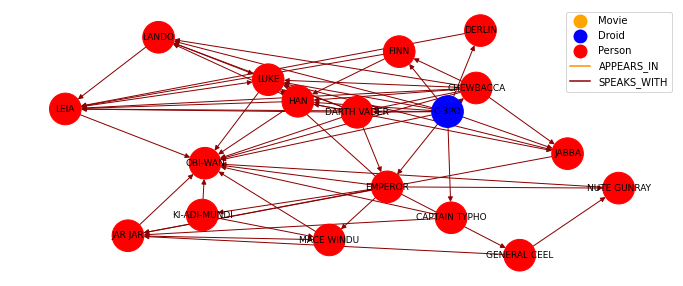

In [8]:
paths = "MATCH p=(ch1)-[*..5]->(ch2) WHERE ch1.name='"+ch1+"' AND ch2.name='"+ch2+"'RETURN p"
drawGraph(driver, paths, node_size=1000, font_size=9, height=5)

## In which movies is my favorte character

MATCH p=(n)-[:APPEARS_IN]->(m:Movie) WHERE n.name='OBI-WAN'RETURN p


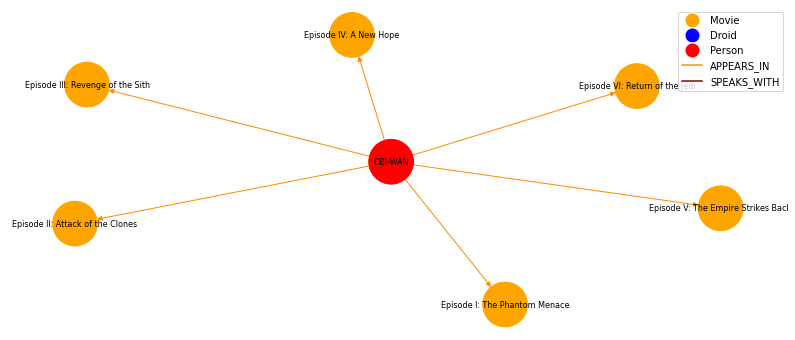

In [5]:
myFavChar = 'OBI-WAN'
movies = "MATCH p=(n)-[:APPEARS_IN]->(m:Movie) WHERE n.name='" + myFavChar + "'RETURN p"
print(movies)
drawGraph(driver, movies, font_size=8, width=14, height=6)

## Who is the most important character

In [6]:
# Close all connections
driver.close()
session.close()
drive = None
session = None